In [1]:
import numpy as np
import networkx as nx
import cvxpy as cp
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
from scipy.stats import poisson, uniform

# Parking Simulation: Toy Example

Due to computational constraints at scale, we iterated our simulation on a smaller toy network first (similar to when we formulated the matrix completion):

## Toy Network

Simple network with 2 intersections:

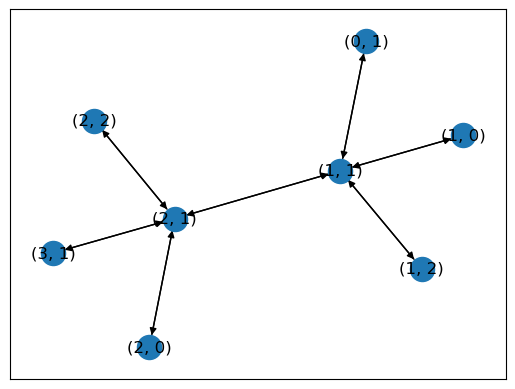

In [2]:
G = nx.grid_2d_graph(4, 3)
D = G.to_directed()

for n in [(0, 0), (0, 2), (3, 0), (3, 2)]:
    D.remove_node(n)
    
for e in [((2, 2), (1, 2)), ((2, 0), (1, 0))]:
    D.remove_edge(*e)
    D.remove_edge(*e[::-1])
    
nx.draw_networkx(D)

We remove edges from the graph above to create a scenario where there are no 2-way roads:

In [3]:
for e in [
    ((1, 1), (1, 0)), ((1, 1), (1, 2)), ((0, 1), (1, 1)),
    ((2, 1), (1, 1)),
    ((2, 1), (2, 0)), ((3, 1), (2, 1)), ((2, 2), (2, 1))
]:
    D.remove_edge(*e)

Computing some graph properties:

In [4]:
# For directed graphs, entry i,j corresponds to an edge from i to j.
A = nx.adjacency_matrix(D, nodelist=list(D.nodes)).todense()

# The incidence matrix assigns each row to a node and each column to an edge.
# -1: the source (tail) of an edge
# 1: the destination (head) of the edge
M = nx.incidence_matrix(D, nodelist=list(D.nodes), edgelist=list(D.edges), oriented=True).todense()

In [5]:
# Dual graph
D_prime=nx.line_graph(D)

# Note: this is the adjacency matrix for the DUAL graph
A_prime = nx.adjacency_matrix(D_prime, nodelist=list(D.edges)).todense()

## Simulations

### Parking Volumes

**Note**: this is just a randomly sampled *placeholder* drawn from a Poisson distribution assuming i.i.d. parking decisions. You will see next time how we draw from the distribution with bounded constraints that reflect the max parking capacity allowed on each street segment. But for now this will suffice...

In [6]:
# Randomly sample parking matrix P for 8 time intervals
T = 8

np.random.seed(42)
P = np.random.poisson(lam=5.0, size=(len(D.edges), T))
print(P.shape)
P

(7, 8)


array([[ 5,  4,  4,  5,  5,  3,  5,  4],
       [ 6,  7,  2,  5,  5,  6,  4,  6],
       [ 6,  1,  7,  2, 11,  4,  3,  8],
       [ 3,  3,  5,  8,  3,  2,  5,  3],
       [ 8, 10,  3,  2,  5,  7,  6,  6],
       [ 2,  4,  9,  7, 11,  8,  3,  2],
       [ 3,  4,  5,  5,  4,  3,  8,  2]])

### Inflow/Outflow

#### Formulation

***Goal***: to formulate an optimization problem to reverse-engineer suitable $F_{\text{in}}$, $F_{\text{out}}$ given a sample parking matrix:


**Variables**:
- $G(V,E)$ is a network (graph) where the nodes/vertices ($V$) represent road intersections and the links/edges ($E$) represent the street segments.
- $F_{\text{in}}(u, v, t)$: Number of vehicles flowing into edge $(u, v)$ over time interval starting at $t$.
- $F_{\text{out}}(u, v, t)$: Number of vehicles flowing out of edge $(u, v)$ over time interval starting at $t$.
- $P(u, v, t)$: Number of vehicles parked on road segment / edge $(u, v)$ at time $t$ (start of the time interval).

**Objective Function**:
Most terms are borrowed from the matrix completion objective function (perhaps it's problematic / circular reasoning to use similar elements to the original objective function?):

$$
\text{minimize } \lambda_3||F_{out}(:, t+1) - F_{out}(:, t)||_F + \lambda_4||F_{in}(:, t+1) - F_{in}(:, t)||_F + \lambda_5||\bar{F} - F||_F
$$

**Constraints**:
1. **Parking Change Consistency**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}(u, v, t) - F_{\text{out}}(u, v, t) = P(u, v, t+1) - P(u, v, t) = \delta P(u, v, t)
$$

2. **Flow Conservation** (around *interior* intersections):

For each edge $(u, v)$ and time interval starting at $t$: the inflow into an edge $(u, v)$ over time interval starting at $t$ must be equal to the sum of outflow from edges incident on the origin $u$ (i.e., edges **going into** intersection $u$), minus the sum of inflow into other edges that share the same origin $u$ (but **different** $v$) over that same interval.

$$
F_{\text{in}}(u, v, t) = \sum_{\forall w \text{; } \exists (w, u) \in E} F_{\text{out}}(w, u, t) - \sum_{\forall w \text{; } \exists (u, w) \in E \text{; } w \neq v} F_{\text{in}}(u, w, t)
$$

$$
F_{\text{in}}(:, t) = A'^\intercal \cdot F_{\text{out}}(:, t) - O \cdot F_{\text{in}}(:, t)
$$
- Where $O$ is an "outgoing" matrix constructed from the incidence matrix $M$ that indicates for each edge $(u, v)$, all the ***other*** edges that share the same origin $u$.

**UPDATE:** This balance can only be applied to edges for which the origin is fully characterized (i.e., we know all the connected edges to that origin). Therefore, it cannot be applied to the outer edges on the boundaries of the network that are "sources" of flow into the whole network.

3. **Non-negativity**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}(u, v, t) \geq 0, \quad F_{\text{out}}(u, v, t) \geq 0
$$

4. **Integer Constraints**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}(u, v, t) \in \mathbb{Z}, \quad F_{\text{out}}(u, v, t) \in \mathbb{Z}
$$

#### Set-up

In [7]:
# Let's construct O using the incidence matrix:
M_in = np.where(M == -1, 1, 0)

# For each edge in M (columns), identify the node where the edge originates from,
# and then append the row of all other edges that share the same origin node
O = []
for e in M_in.T:
    idx = np.argmax(e)
    O.append(M_in[idx])
O = np.array(O)

# subtract the identity matrix to ensure that the edge itself is not counted in its outflow.
O = O - np.eye(len(D.edges), len(D.edges))

**UPDATE:** the flow conservation constraint can only be applied to edges for which the origin is fully characterized (i.e., we know all the connected edges to that origin). In practice, we shall construct a binary "mask" that zeroes out rows pertaining to edges that shouldn't be included in this constraint:

In [8]:
# Create a mask that will be multipled (element-wise) against the matrices in the flow conservation constraint:
mask = np.ones_like(P)
for idx, e in enumerate(D.edges):
    if len(D.in_edges(e[0])) == 0:
        mask[idx, :] = 0
mask

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]])

#### Gurobi Solver

In [9]:
%%time

# Decision Variables
F_in = cp.Variable((len(D.edges), T), integer=True)
F_out = cp.Variable((len(D.edges), T), integer=True)

# Hyperparameters
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

expr3 = l3 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')
expr4 = l4 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr5 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

# Objective
objective = cp.Minimize(expr3 + expr4 + expr5)

# Constraints
constraints = [
    F_in >= 0,  # Ensure each element of F_in is positive
    F_out >= 0  # Ensure each element of F_out is positive    
]

# Parking Change Consistency
for t in range(0, T-1):
    constraints.append(F_in[:, t] - F_out[:, t] == P[:, t+1] - P[:, t])

# Flow Conservation
constraints.append(cp.multiply(mask, F_in) == cp.multiply(mask, A_prime.T @ F_out - O @ F_in))

# Formulating the problem
problem = cp.Problem(objective, constraints)

problem.solve(solver=cp.GUROBI, reoptimize=False)

problem.status

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-10
CPU times: user 20min 14s, sys: 59.6 s, total: 21min 13s
Wall time: 3min 15s


'optimal'

## Sense Checks
Let's demonstrate how the constraints are manifested in results:

$$
F_{\text{in}}(u, v, t) - F_{\text{out}}(u, v, t) = P(u, v, t+1) - P(u, v, t) = \delta P(u, v, t)
$$

$$
P(u, v, t) + F_{\text{in}}(u, v, t) - F_{\text{out}}(u, v, t) = P(u, v, t+1)
$$

In [10]:
pd.DataFrame(P, index=D.edges)

0   1  2  3   4  5  6  7
(1, 0) (1, 1)  5   4  4  5   5  3  5  4
(1, 1) (0, 1)  6   7  2  5   5  6  4  6
       (2, 1)  6   1  7  2  11  4  3  8
(1, 2) (1, 1)  3   3  5  8   3  2  5  3
(2, 0) (2, 1)  8  10  3  2   5  7  6  6
(2, 1) (3, 1)  2   4  9  7  11  8  3  2
       (2, 2)  3   4  5  5   4  3  8  2

In [11]:
# Recovering the parking matrix for t+1 at each t
pd.DataFrame(P + F_in.value - F_out.value, index=D.edges, columns=range(1, 9)).round(0).astype(int)

1  2  3   4  5  6  7   8
(1, 0) (1, 1)   4  4  5   5  3  5  4   3
(1, 1) (0, 1)   7  2  5   5  6  4  6   7
       (2, 1)   1  7  2  11  4  3  8  10
(1, 2) (1, 1)   3  5  8   3  2  5  3   2
(2, 0) (2, 1)  10  3  2   5  7  6  6   6
(2, 1) (3, 1)   4  9  7  11  8  3  2   1
       (2, 2)   4  5  5   4  3  8  2   0

$$
F_{\text{in}}(u, v, t) = \sum_{\forall w \text{; } \exists (w, u) \in E} F_{\text{out}}(w, u, t) - \sum_{\forall w \text{; } \exists (u, w) \in E \text{; } w \neq v} F_{\text{in}}(u, w, t)
$$

In [12]:
F_in = pd.DataFrame(F_in.value, index=D.edges).round(0).astype(int)
F_in

0  1  2  3  4  5  6  7
(1, 0) (1, 1)  2  4  4  4  0  4  3  3
(1, 1) (0, 1)  4  0  5  2  5  2  4  4
       (2, 1)  2  7  0  9  0  3  6  5
(1, 2) (1, 1)  3  5  5  2  2  6  4  4
(2, 0) (2, 1)  5  1  2  7  3  3  3  3
(2, 1) (3, 1)  6  6  4  4  4  2  4  4
       (2, 2)  4  3  4  0  4  6  0  2

In [13]:
F_out = pd.DataFrame(F_out.value, index=D.edges).round(0).astype(int)
F_out

0  1  2  3  4  5  6  7
(1, 0) (1, 1)  3  4  3  4  2  2  4  4
(1, 1) (0, 1)  3  5  2  2  4  4  2  3
       (2, 1)  7  1  5  0  7  4  1  3
(1, 2) (1, 1)  3  3  2  7  3  3  6  5
(2, 0) (2, 1)  3  8  3  4  1  4  3  3
(2, 1) (3, 1)  4  1  6  0  7  7  5  5
       (2, 2)  3  2  4  1  5  1  6  4

E.g., for edge: `(1, 1) --> (2, 1)`

In [14]:
F_in.loc[((1, 1), (2, 1)), :]

,,0,1,2,3,4,5,6,7
"(1, 1)","(2, 1)",2,7,0,9,0,3,6,5


In [15]:
(
    F_in.loc[((1, 1), (2, 1)), :].values 
        == F_out.loc[((1, 0), (1, 1)), :].values 
            + F_out.loc[((1, 2), (1, 1)), :].values 
            - F_in.loc[((1, 1), (0, 1)), :].values
).all()

True